In [72]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import math  
from scipy.fft import fft, fftfreq, ifft


In [132]:

# Compute RMS value of the signal
#Function that Calculate Root Mean Square  
def rmsValue(arr, n): 
    square = 0
    mean = 0.0
    root = 0.0
      
    #Calculate square 
    for i in range(0,n): 
        square += (arr[i]**2) 
      
    #Calculate Mean  
    mean = (square / (float)(n)) 
      
    #Calculate Root 
    root = math.sqrt(mean) 
      
    return root 
    
def fft_to_db(x):
    if x > 0:
        fft = 20 * math.log10(x/prms)
        if fft < 0:
            fft = 0
    else: 
        fft = 0
    return fft

In [155]:
data = pd.read_excel("anechoic_3200rpm.xlsx")

# find negative start point
val = data.crank_angle[0]

print("First value ", val)

# Shift the first angle to 0 degrees to then convert to time
if val < 0:
    data.crank_angle = data.crank_angle.apply(lambda x: x - val)

# Number of times to multiply the data to find the frequencies. 
n = 20
crank_angle = data.crank_angle
pressure = data.total_pressure
final_val = data.crank_angle[len(data)-1]

for i in range(1,n+1):
    new_ca = crank_angle+i*final_val
    new_data = pd.DataFrame([new_ca, pressure]).T
    data = data.append(new_data)

rpm = 3200
rps = rpm/60
seconds_per_rev = 1/rps
data["time"] = data.crank_angle.apply(lambda x: (x/360)*seconds_per_rev)
data.head()
len(data)

First value  -94.0


15183

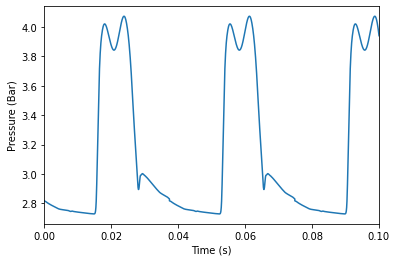

In [157]:
plt.plot(data.time, data.total_pressure)
plt.xlabel("Time (s)")
plt.ylabel("Pressure (Bar)")
plt.xlim([0, 0.1])
plt.savefig("pressure_wave_input.png")
plt.show()

In [158]:
pressure = data.total_pressure
pressure_array = np.array(pressure)
time = data.time
pressure_array = pressure.values.tolist()

prms = rmsValue(np.array(data.total_pressure), len(data))

print(f"final time value {time.iloc[-1]}")

final time value 0.7864062500000001


Total sampling time 0.75s


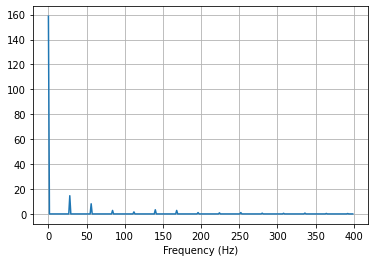

In [170]:
# Number of sample points
N = 600

# sample spacing
T = 1.0 / 800

# Sampling frequency is 1/T


print(f"Total sampling time {N*T}s")

y = pressure_array

yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.xlabel("Frequency (Hz)")
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.savefig("anechoic_3200rpm_freq_breakdown.png")
plt.show()
#print(xf)



In [171]:
fft_df = pd.DataFrame({"fft_raw": np.abs(yf)[0:N//2], "freq": xf})
fft_df["fft_db"] = fft_df.fft_raw.map(lambda x: fft_to_db(x))
fft_df.head()



,fft_raw,freq,fft_db
0,4.761040e+04,0.000000,83.519999
1,3.924222e-13,1.333333,0.000000
2,6.210370e-14,2.666667,0.000000
3,2.419224e-13,4.000000,0.000000
4,2.612631e-13,5.333333,0.000000


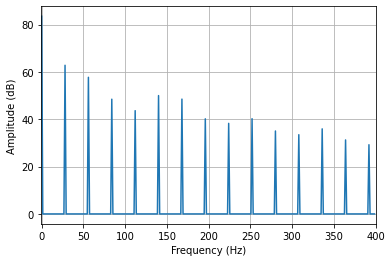

In [172]:
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.plot(xf, fft_df.fft_db[0:N//2])
plt.grid()
plt.xlim([-1, 400])
plt.savefig("anechoic_3200rpm_freq_breakdown_dB.png")
plt.show()

In [173]:
#Create the sample points
final_time = time.iloc[-1]
x = np.linspace(0, final_time, N)

fft_filtered = fft_df[fft_df.fft_db > 0][0:9]
fft_filtered.head()



,fft_raw,freq,fft_db
0,47610.404047,0.0,83.519999
21,4385.902572,28.0,62.807141
42,2442.585946,56.0,57.722959
63,841.738815,84.0,48.469509
84,482.175906,112.0,43.630072


In [169]:
# Turn the frequencies back into sinusoids
y = np.ones(len(x))*fft_filtered.fft_raw.iloc[0]
for i in range(1, len(fft_filtered)):
    row = fft_filtered.iloc[i]
    amp = row.fft_raw
    fre = row.freq
    func = amp * np.sin(np.pi * fre * x)
    y = y + func


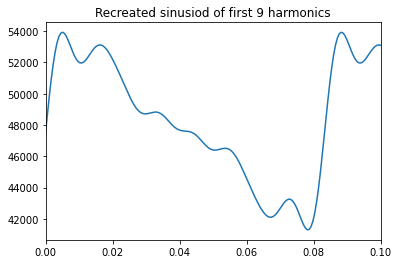

In [167]:
plt.plot(x,y)
plt.title(f"Recreated sinusiod of first {len(fft_filtered)} harmonics")
plt.xlim([0, 0.1])
plt.savefig(f"recreated_pressure_wave_{len(fft_filtered)}_harmonics.png")
plt.show()